# Exercise Round 10

## Exercise 1

(a) The Wiener velocity model has $\mathbf{x} = [p,\dot{p}]$:
$$
\mathbf{x}_n = \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix} \, \mathbf{x}_{n-1} + \mathbf{q}_n, \quad \mathbf{q}_n \sim N\left( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, q_w \begin{bmatrix} \Delta t^3/3 & \Delta t^2/2 \\ \Delta t^2/2 & \Delta t \end{bmatrix} \right)
$$
The measurement model is then given as
$$
y_n = \sin(x_{1,n}) + r_n
$$

(b) The Jacobian of $g(\mathbf{x}) = \sin(x_1)$ is $G(\mathbf{x}) = \begin{bmatrix} \cos(x_1) & 0 \end{bmatrix}$. Because the dynamics is linear Gaussian, the prediction step is just the linear Kalman prediction.

It is always a good idea to check the Jacobian numerically either using finite differences or by using automatic differentiation.

In [7]:
%matplotlib inline
import numpy as np
import scipy.linalg as linalg
import scipy.integrate as integrate
import math
import matplotlib.pyplot as plt

dt  = 0.1
q_w = 0.1
F = np.array([[1,dt],[0,1]])
print(F)

Q = q_w * np.array([[dt**3/3,dt**2/2],[dt**2/2,dt]])
print(Q)

sd = 0.5
R = np.array([[sd**2]])
print(R)

[[1.  0.1]
 [0.  1. ]]
[[3.33333333e-05 5.00000000e-04]
 [5.00000000e-04 1.00000000e-02]]
[[0.25]]


In [9]:
def g_fun(x):
    return np.array([np.sin(x[0])])

def G_fun(x):
    return np.array([[np.cos(x[0]),0]])

import autograd.numpy as anp   # Thinly-wrapped version of Numpy # install it: pip install autograd
from autograd import jacobian

def ag_fun(x):
    return anp.array([anp.sin(x[0])])

x = np.random.normal(0,1,2)
J1 = G_fun(x)
J2 = jacobian(ag_fun)(x)
print(linalg.norm(J1 - J2))


0.0


(c) Simulate data from the model and implement an EKF.

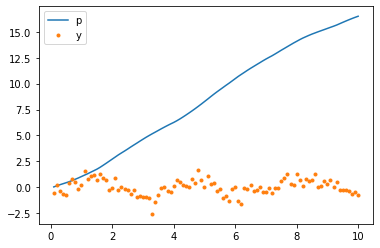

In [3]:
steps = 100
m0 = np.array([0,1])  # Suitable initial mean
P0 = 0.01 * np.eye(2) # Suitable initial covariance

LQ = linalg.cholesky(Q, lower=True)
L0 = linalg.cholesky(P0, lower=True)

T = np.zeros((steps,))
X = np.zeros((steps,2))
Y = np.zeros((steps,1))

x = m0 + L0 @ np.random.normal(size=(m0.shape))
t = 0

for n in range(steps):
    q = LQ @ np.random.normal(size=x.shape)
    x = F @ x + q
    r = sd * np.random.normal()
    y = g_fun(x) + r
    t = t + dt
    T[n] = t
    X[n,:] = x
    Y[n,:] = y

plt.clf()
plt.plot(T,X[:,0],T,Y[:,0],'.')
plt.legend(['p','y'])

This is the extended Kalman filter (EKF):

0.449259284526535


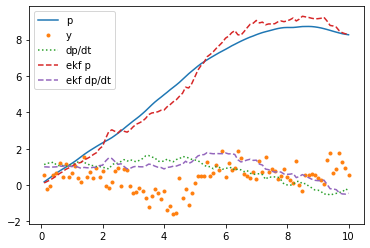

In [35]:
m = m0
P = P0
ekf_m = np.zeros((Y.shape[0],m.shape[0]))
ekf_P = np.zeros((Y.shape[0],P.shape[0],P.shape[1]))
for n in range(Y.shape[0]):
    # Prediction
    m = F @ m
    P = F @ P @ F.T + Q
    # Update
    G = G_fun(m)
#    G = jacobian(ag_fun)(m)
    S = G @ P @ G.T + R
    K = P @ G.T @ linalg.inv(S)
    m = m + K @ (Y[n] - g_fun(m))
    P = P - K @ S @ K.T
    ekf_m[n,:] = m
    ekf_P[n,:,:] = P

print(np.sqrt(((ekf_m[:,0]-X[:,0])**2).mean()))
    
plt.clf()
plt.plot(T,X[:,0],T,Y[:,0],'.',T,X[:,1],':',T,ekf_m[:,0],'--',T,ekf_m[:,1],'--')
plt.legend(['p','y','dp/dt','ekf p','ekf dp/dt'])

(d) Implement unscented Kalman filter (UKF) for the model

In [26]:
# Precompute the UT weights
d = m0.shape[0]
alpha = 1
beta = 0
kappa = 3-d

lam = alpha**2 * (d + kappa) - d
WM = np.zeros((2*d+1,))
WC = np.zeros((2*d+1,))

for j in range(WM.shape[0]):
    if j==1:
        wm = lam / (d + lam)
        wc = lam / (d + lam) + (1 - alpha**2 + beta)
    else:
        wm = 1 / (2 * (d + lam))
        wc = wm

    WM[j] = wm
    WC[j] = wc

print(WM)
print(WC)

[0.16666667 0.33333333 0.16666667 0.16666667 0.16666667]
[0.16666667 0.33333333 0.16666667 0.16666667 0.16666667]


0.4452465828540054


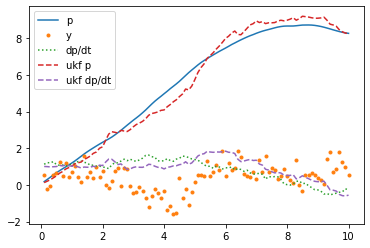

In [33]:
m = m0
P = P0
ukf_m = np.zeros((Y.shape[0],m.shape[0]))
ukf_P = np.zeros((Y.shape[0],P.shape[0],P.shape[1]))
d = m0.shape[0]

for n in range(Y.shape[0]):
    # Prediction
    m = F @ m
    P = F @ P @ F.T + Q
    
    # Update
    # First form the sigma points from m,P
    A = linalg.cholesky(P, lower=True)
    SX = np.zeros((2*d+1,d))
    SX[0,:] = m
    for i in range(d):
        SX[1+i,:]   = m + np.sqrt(d + lam) * A[:,i]
        SX[d+1+i,:] = m - np.sqrt(d + lam) * A[:,d-i-1]

    # Propagate sigma-points though g
    SY = np.zeros((SX.shape[0], Y.shape[1]))
    for i in range(SX.shape[0]):
        SY[i,:] = g_fun(SX[i,:])
    
    # Compute the updated mean and covariance
    mu = np.zeros((SY.shape[1],))
    S  = np.zeros((SY.shape[1],SY.shape[1]))
    C  = np.zeros((SX.shape[1],SY.shape[1]))
    for i in range(SY.shape[0]):
        mu = mu + WM[i] * SY[i,:]
    for i in range(SY.shape[0]):
        S = S + WC[i] * np.outer(SY[i,:] - mu, SY[i,:] - mu)
        C = C + WC[i] * np.outer(SX[i,:] - m, SY[i,:] - mu)
    S = S + R
    
    # Compute the gain and updated mean and covariance  
    K = C @ linalg.inv(S)
    m = m + K @ (Y[n] - mu)
    P = P - K @ S @ K.T

    ukf_m[n,:] = m
    ukf_P[n,:,:] = P

print(np.sqrt(((ukf_m[:,0]-X[:,0])**2).mean()))
    
plt.clf()
plt.plot(T,X[:,0],T,Y[:,0],'.',T,X[:,1],':',T,ukf_m[:,0],'--',T,ukf_m[:,1],'--')
plt.legend(['p','y','dp/dt','ukf p','ukf dp/dt'])

## Exercise 2

EKF tracking of robot with position measurements.

(a) Euler-Maruyama and linearization based approximation of
$$
   dp^x/dt = v \, \cos(\phi) + w_1 \\
   dp^y/dt = v \, \sin(\phi) + w_2 \\
   d\phi/dt = \omega + w_3
$$
is
$$
   p^x_n = p^x_{n-1} + v_{n-1} \, \cos(\phi_{n-1}) \, \Delta t + e_1 \\
   p^y_n = p^y_{n-1} + v_{n-1} \, \sin(\phi_{n-1}) \, \Delta t + e_2 \\
   \phi_n = \phi_{n-1} + \omega_{n-1} \, \Delta t + e_3
$$
with $e \sim N(0,Q)$ with $Q = \Delta t \, \mathrm{diag}(q_1,q_2,q_3)$. We assume that $v$ and $\omega$ are constant on the interval (ZOH). The
measurements are
$$
   y_1 = p^x + r_1 \\
   y_2 = p^y + r_2
$$

(b) Simulate states (as in Ex 7) and measurements

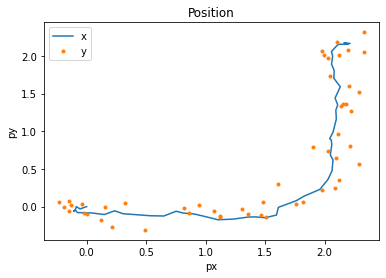

In [36]:
%matplotlib inline
import numpy as np
import scipy.linalg as linalg
import scipy.integrate as integrate
import math
import matplotlib.pyplot as plt

def fr(x,u):
    return np.array([u[0] * np.cos(x[2]), u[0] * np.sin(x[2]), u[1]])

x0 = np.array([0,0,0])
dt = 0.1
tr = np.arange(0,5+dt,dt)

V = np.zeros((tr.shape[0],))
Omega = np.zeros((tr.shape[0],))
for k in range(tr.shape[0]):
    if tr[k] < 1:
        V[k] = tr[k]
    elif tr[k] >= 4:
        V[k] = 5 - tr[k]
    else:
        V[k] = 1
        
    if tr[k] < 2 or tr[k] >= 3:
        Omega[k] = 0
    else:
        Omega[k] = math.pi / 2

xs = np.zeros((tr.shape[0],3))
ys = np.zeros((tr.shape[0],2))

cx = x0
q1 = 0.01
q2 = 0.01
q3 = 0.01
G  = np.array([[1,0,0],[0,1,0]])
sd = 0.1
R = np.array([[sd**2]])

ys[0,:] = G @ cx + sd * np.random.normal(size=(2,))
for k in range(1,tr.shape[0]):
    u  = np.array([V[k-1],Omega[k-1]])
    dt = tr[k] - tr[k-1]
    v  = np.diag(np.sqrt(dt * np.array([q1,q2,q3]))) @ np.random.normal(size=(3,))
    cx = cx + dt * fr(cx,u) + v
    ys[k,:] = G @ cx + sd * np.random.normal(size=(2,))
    xs[k,:] = cx;
    
plt.clf()
plt.plot(xs[:,0],xs[:,1],ys[:,0],ys[:,1],'.')
plt.xlabel('px')
plt.ylabel('py')
plt.title('Position')
plt.legend(['x','y'])

(c) Extended Kalman filter for the robot

In [37]:
def f_fun(x,v,omega,dt):
    return np.array([x[0] + v * np.cos(x[2]) * dt, x[1] + v * np.sin(x[2]) * dt, x[2] + omega * dt])

def F_fun(x,v,omega,dt):
    return np.array([[1,0,-dt*v*np.sin(x[2])],[0,1,dt*v*np.cos(x[2])],[0,0,1]])
                     
# Check derivative with autodiff
import autograd.numpy as anp   # Thinly-wrapped version of Numpy # install it: pip install autograd
from autograd import jacobian

v = np.random.normal()
omega = np.random.normal()
dt = 0.1
def af_fun(x):
    return anp.array([x[0] + v * anp.cos(x[2]) * dt, x[1] + v * anp.sin(x[2]) * dt, x[2] + omega * dt])

x = np.random.normal(size=(3,))
J1 = F_fun(x,v,omega,dt)
J2 = jacobian(af_fun)(x)
print(J1)
print(J2)
print(linalg.norm(J1 - J2))

[[ 1.00000000e+00  0.00000000e+00 -1.17290192e-04]
 [ 0.00000000e+00  1.00000000e+00  4.06131538e-02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00  0.00000000e+00 -1.17290192e-04]
 [ 0.00000000e+00  1.00000000e+00  4.06131538e-02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
0.0


0.08776478883964524
0.10205006370989057


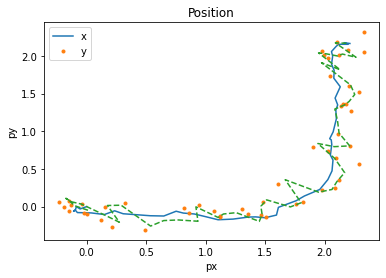

In [38]:
m0 = np.zeros((3,))
P0 = 0.1**2 * np.eye(3)
Q  = np.diag(dt * np.array([q1,q2,q3]))

m = m0
P = P0
ekf_m = np.zeros((ys.shape[0],m.shape[0]))
ekf_P = np.zeros((ys.shape[0],P.shape[0],P.shape[1]))
for n in range(ys.shape[0]):
    # Prediction
    if n > 0:
        f = f_fun(m,V[n-1],Omega[n-1],dt)
        F = F_fun(m,V[n-1],Omega[n-1],dt)
        m = f
        P = F @ P @ F.T + Q
    # Update
    S = G @ P @ G.T + R
    K = P @ G.T @ linalg.inv(S)
    m = m + K @ (ys[n] - G @ m)
    P = P - K @ S @ K.T
    ekf_m[n,:] = m
    ekf_P[n,:,:] = P

print(np.sqrt(((ekf_m[:,0:2]-xs[:,0:2])**2).mean()))
print(np.sqrt(((ys-xs[:,0:2])**2).mean()))
plt.clf()
plt.plot(xs[:,0],xs[:,1],ys[:,0],ys[:,1],'.',ekf_m[:,0],ekf_m[:,1],'--')
plt.xlabel('px')
plt.ylabel('py')
plt.title('Position')
plt.legend(['x','y'])

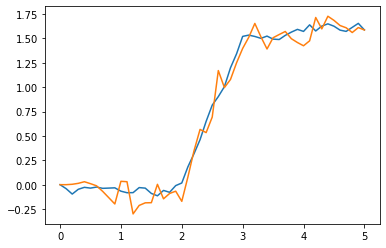

In [39]:
plt.clf()
plt.plot(tr,xs[:,2],tr,ekf_m[:,2])

## Exercise 3

The measurement model is now
$$
y_1 = \sqrt{(x_1 - s_x)^2 + (x_2 - s_y)^2} + r_1 \\
y_2 = \arctan\left( \frac{x_2 - s_y}{x_1 - s_x} \right) + r_2
$$

Text(0.5, 1.0, 'Position')

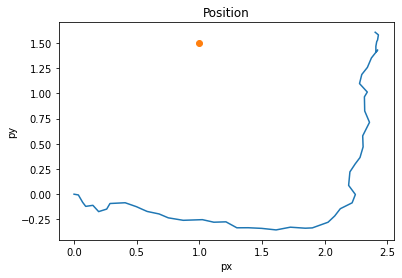

In [41]:
%matplotlib inline
import numpy as np
import scipy.linalg as linalg
import scipy.integrate as integrate
import math
import matplotlib.pyplot as plt

def fr(x,u):
    return np.array([u[0] * np.cos(x[2]), u[0] * np.sin(x[2]), u[1]])

sx = 1
sy = 1.5

def g_fun(x):
    return np.array([np.sqrt((x[0]-sx)**2 + (x[1]-sy)**2), np.arctan2(sy-x[1],sx-x[0])-x[2]])

x0 = np.array([0,0,0])
dt = 0.1
tr = np.arange(0,5+dt,dt)

V = np.zeros((tr.shape[0],))
Omega = np.zeros((tr.shape[0],))
for k in range(tr.shape[0]):
    if tr[k] < 1:
        V[k] = tr[k]
    elif tr[k] >= 4:
        V[k] = 5 - tr[k]
    else:
        V[k] = 1
        
    if tr[k] < 2 or tr[k] >= 3:
        Omega[k] = 0
    else:
        Omega[k] = math.pi / 2

xs = np.zeros((tr.shape[0],3))
ys = np.zeros((tr.shape[0],2))

cx = x0
q1 = 0.01
q2 = 0.01
q3 = 0.01
G  = np.array([[1,0,0],[0,1,0]])
sd = 0.1
R = np.array([[sd**2]])

ys[0,:] = g_fun(cx) + sd * np.random.normal(size=(2,))
for k in range(1,tr.shape[0]):
    u  = np.array([V[k-1],Omega[k-1]])
    dt = tr[k] - tr[k-1]
    v  = np.diag(np.sqrt(dt * np.array([q1,q2,q3]))) @ np.random.normal(size=(3,))
    cx = cx + dt * fr(cx,u) + v
    ys[k,:] = g_fun(cx) + sd * np.random.normal(size=(2,))
    xs[k,:] = cx;
    
plt.clf()
plt.plot(xs[:,0],xs[:,1],sx,sy,'o')
plt.xlabel('px')
plt.ylabel('py')
plt.title('Position')


Text(0.5, 1.0, 'Measurements')

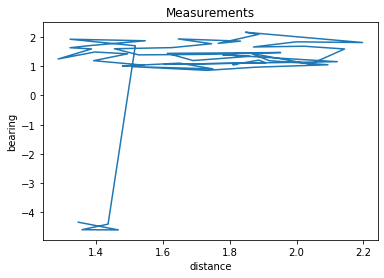

In [42]:
plt.clf()
plt.plot(ys[:,0],ys[:,1])
plt.xlabel('distance')
plt.ylabel('bearing')
plt.title('Measurements')


In [48]:
def G_fun(x):
    return np.array([[(x[0]-sx)/np.sqrt((x[0]-sx)**2 + (x[1]-sy)**2),(x[1]-sy)/np.sqrt((x[0]-sx)**2 + (x[1]-sy)**2),0],
                    [(sy-x[1])/((x[0]-sx)**2 + (x[1]-sy)**2),(x[0]-sx)/((x[0]-sx)**2 + (x[1]-sy)**2),-1]])

# Check derivative with autodiff
import autograd.numpy as anp   # Thinly-wrapped version of Numpy # install it: pip install autograd
from autograd import jacobian

def ag_fun(x):
    return anp.array([anp.sqrt((x[0]-sx)**2 + (x[1]-sy)**2), anp.arctan2(sy-x[1],sx-x[0])-x[2]])

x = np.random.normal(size=(3,))
J1 = G_fun(x)
J2 = jacobian(ag_fun)(x)
print(J1)
print(J2)
print(linalg.norm(J1 - J2))

[[ 0.6545405  -0.75602694  0.        ]
 [ 0.56223713  0.48676436 -1.        ]]
[[ 0.6545405  -0.75602694  0.        ]
 [ 0.56223713  0.48676436 -1.        ]]
1.5700924586837752e-16


0.22638028546676595
1.6847193986649793


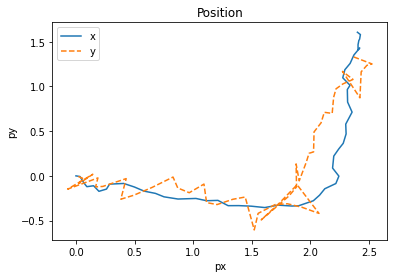

In [52]:
def f_fun(x,v,omega,dt):
    return np.array([x[0] + v * np.cos(x[2]) * dt, x[1] + v * np.sin(x[2]) * dt, x[2] + omega * dt])

def F_fun(x,v,omega,dt):
    return np.array([[1,0,-dt*v*np.sin(x[2])],[0,1,dt*v*np.cos(x[2])],[0,0,1]])

m0 = np.zeros((3,))
P0 = 0.1**2 * np.eye(3)
Q  = np.diag(dt * np.array([q1,q2,q3]))

m = m0
P = P0
ekf_m = np.zeros((ys.shape[0],m.shape[0]))
ekf_P = np.zeros((ys.shape[0],P.shape[0],P.shape[1]))
for n in range(ys.shape[0]):
    # Prediction
    if n > 0:
        f = f_fun(m,V[n-1],Omega[n-1],dt)
        F = F_fun(m,V[n-1],Omega[n-1],dt)
        m = f
        P = F @ P @ F.T + Q
    # Update
    g = g_fun(m)
    G = G_fun(m)
    S = G @ P @ G.T + R
    K = P @ G.T @ linalg.inv(S)
    nu = ys[n] - g
    if nu[1] > np.pi:
        nu[1] = nu[1] - 2*np.pi
    elif nu[1] < -np.pi:
        nu[1] = nu[1] + 2*np.pi
    
    m = m + K @ nu
    P = P - K @ S @ K.T
    ekf_m[n,:] = m
    ekf_P[n,:,:] = P

print(np.sqrt(((ekf_m[:,0:2]-xs[:,0:2])**2).mean()))
print(np.sqrt(((ys-xs[:,0:2])**2).mean()))
plt.clf()
plt.plot(xs[:,0],xs[:,1],ekf_m[:,0],ekf_m[:,1],'--')
plt.xlabel('px')
plt.ylabel('py')
plt.title('Position')
plt.legend(['x','y'])

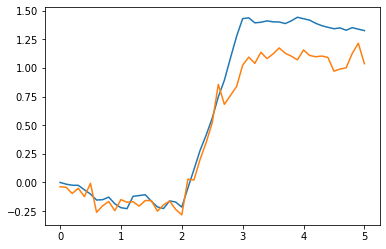

In [50]:
plt.clf()
plt.plot(tr,xs[:,2],tr,ekf_m[:,2])